In [3]:
using Distributions
using LinearAlgebra
import ProgressMeter
using WAV
using Plots
using AIDA

In [4]:
# clean speech
cl, fs = wavread("../../sound/speech/clean/sp01.wav")
σ² = 0.0001
# white noise
wn = sqrt(σ²)*randn(length(cl))
# noised speech
ns = cl .+ wn

22529×1 Matrix{Float64}:
 -0.00993016169316019
  0.005322326789662105
  0.015477127336391935
  0.009025569152072963
  0.0028348399474453527
 -0.01652821707124002
 -0.017138650670796646
  0.007440443649546666
 -0.0002893105599968581
  0.01103970529964
  0.002625010151957976
  0.009462224876057192
  0.0025057131648016802
  ⋮
  0.0037436241103878383
 -0.0032648016514661487
  0.00058874446347165
 -0.006563545526537971
  0.006157650760672509
 -0.002730925439481576
  0.009615423905937595
 -0.0032801188388135254
 -0.008806288961548982
 -0.018515804917730506
 -0.002507452719963916
  0.01886553048002511

In [5]:
cl_seg = get_frames(cl, fs)
ns_seg = get_frames(ns, fs)
totseg = size(ns_seg, 1)

376

In [9]:
ar_order = 10
vmp_iter = 50
fe_ar = zeros(totseg, vmp_iter)
fe_gaussian = zeros(totseg, vmp_iter);

In [11]:
ProgressMeter.@showprogress for segnum in 1:totseg
    inputs, outputs = ar_ssm(ns_seg[segnum, :], ar_order)
    _, _, _, _, fe = lar_inference(outputs, vmp_iter, priors=Dict(:aτ => 1e-4, :bτ => 1e-4, 
                                                                  :aγ => 1e-4, :bγ => 1e-4, 
                                                                  :order => ar_order))
    fe_ar[segnum, :] = fe
    
    _, _, fe = gaussian_inference(outputs, vmp_iter, priors=Dict(:aτ => 1e-4, :bτ => 1e-4))
    
    fe_gaussian[segnum, :] = fe
end

Progress: 100%|█████████████████████████████████████████| Time: 0:11:01


In [12]:
vad = [x[end] < y[end] for (x, y) in zip(eachrow(fe_ar), eachrow(fe_gaussian))];

In [13]:
rsegs = findall(isequal(1), vad)
nsegs = findall(isequal(0), vad);

In [14]:
rseg = rand(rsegs)
nseg = rand(nsegs)
println("$(rseg), $(nseg)")

170, 337


In [15]:
inv(var(sum([ns_seg[nseg, :] for nseg in nsegs])))

19.060866027302517

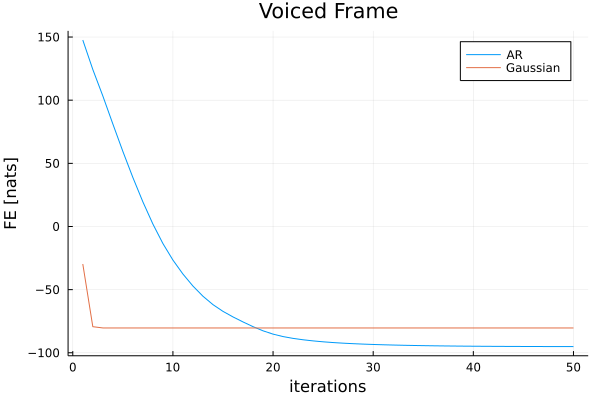

In [17]:
plot(fe_ar[rseg, :], label="AR")
plot!(fe_gaussian[rseg, :], label="Gaussian", ylabel="FE [nats]", xlabel="iterations", title="Voiced Frame")

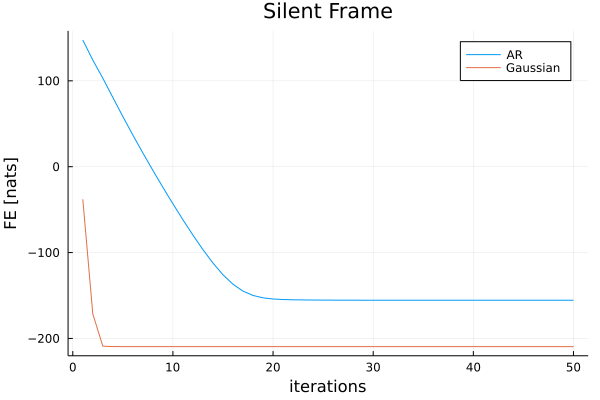

In [15]:
plot(fe_ar[nseg, :], label="AR")
plot!(fe_gaussian[nseg, :], label="Gaussian", ylabel="FE [nats]", xlabel="iterations", title="Silent Frame")

In [16]:
println("$(fe_gaussian[rseg, :][end]), $(fe_ar[rseg, :][end])")

-112.82473415666084, -132.077991538481


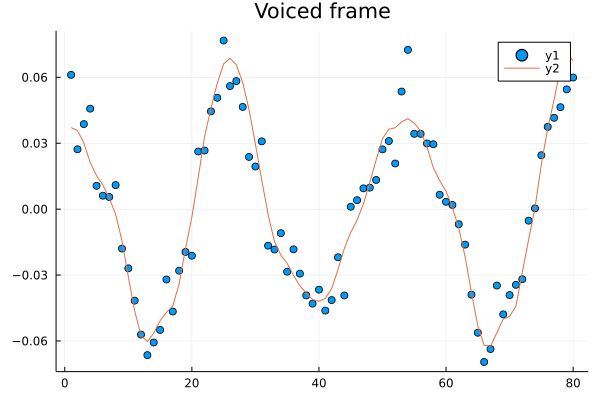

In [17]:
scatter(ns_seg[rseg, :])
plot!(cl_seg[rseg, :], title="Voiced frame")

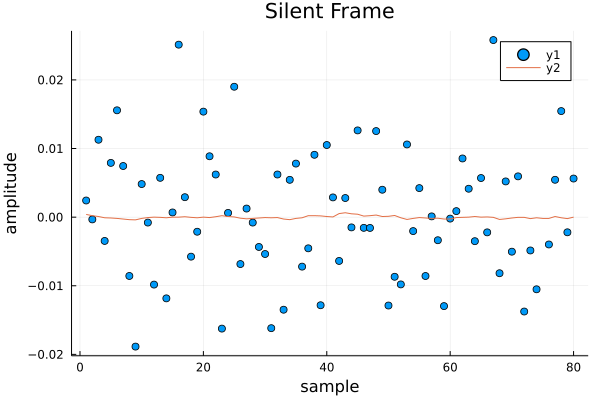

In [18]:
scatter(ns_seg[nseg, :])
plot!(cl_seg[nseg, :], ylabel="amplitude", xlabel="sample", title="Silent Frame")

In [19]:
# check = get_signal(hcat([ns_seg[nseg, :] for nseg in nsegs]...)', 8000)
# using WAV
# wavwrite(check, fs, "check.wav")